In [1]:
# Import libraries
import pickle
import http.client, urllib.parse
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fastai.tabular.all as fastai
np.set_printoptions(linewidth=130)
import torch
import json

load_dotenv()
key = os.getenv('API_KEY')

# longLats pickle
def load_pkl():
  longLats = pickle.load(open('./longLat.pkl', 'rb'))
  print(f"longLats loaded. {len(longLats)}")
  return longLats
def dump_pkl(longLats):
    pickle.dump(longLats, open('./longLat.pkl', 'wb'))
    print(f"pickle dumped. {len(longLats)}")
longLats = load_pkl()

# clean up data: area, date, floor, price
def load_csv():
  #return pd.read_csv('./data/Woodlands_June22_May23.csv')
  return pd.read_csv('./data/resale-flat-from-jan-2017.csv')
floor_dict = { f'0{i*3+1} TO 0{i*3+3}' if i < 3 else f'{i*3+1} TO {i*3+3}': i*3+2  for i in range(17)  }
def floor_cleanup(df):
  df['floor'] = df.storey_range.apply(lambda x:float(floor_dict[x]) if isinstance(x,str) else x)
  df.drop(['storey_range'], axis=1, inplace=True)
  return df
date_dict = { f'20{17+i}-0{j+1}' if j < 9 else f'20{17+i}-{j+1}': i*12+j  for i in range(7) for j in range(12)  }
def date_cleanup(df):
  df['date'] = df.month.apply(lambda x:float(date_dict[x]) if isinstance(x,str) else x)
  df.drop(['month'], axis=1, inplace=True)
  return df
def load_and_cleanup():
  df = load_csv()
  df = floor_cleanup(df)
  df = date_cleanup(df)
  return df

df = load_and_cleanup()
df.describe()
date_max = df.date.max()
town = 'Bukit_Merah'
df = df[(df.town==town.replace('_', ' ').upper()) & (df.date > date_max-12)]

from pathlib import Path
file = Path(f'./data/{town}_June22_May23.csv')
df.to_csv(file,index=False)
df


longLats loaded. 3778


,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
127994,BUKIT MERAH,1 ROOM,7,TELOK BLANGAH CRES,31.0,Improved,1975,51 years 10 months,248000.0,2.0,65.0
127995,BUKIT MERAH,2 ROOM,48,MOH GUAN TER,44.0,Standard,1973,49 years 07 months,432000.0,2.0,65.0
127996,BUKIT MERAH,2 ROOM,76,TELOK BLANGAH DR,44.0,Improved,1978,54 years 08 months,240000.0,8.0,65.0
127997,BUKIT MERAH,3 ROOM,119,BT MERAH VIEW,65.0,Improved,1983,59 years 08 months,325000.0,2.0,65.0
127998,BUKIT MERAH,3 ROOM,129,BT MERAH VIEW,65.0,Improved,1973,50 years 02 months,362000.0,11.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
152633,BUKIT MERAH,5 ROOM,74A,REDHILL RD,115.0,Improved,2005,81 years 07 months,898000.0,2.0,76.0
152634,BUKIT MERAH,5 ROOM,17,TELOK BLANGAH CRES,119.0,Improved,2002,77 years 09 months,850000.0,20.0,76.0
152635,BUKIT MERAH,5 ROOM,14A,TELOK BLANGAH CRES,119.0,Improved,1999,75 years 06 months,808000.0,8.0,76.0
152636,BUKIT MERAH,5 ROOM,26,TELOK BLANGAH CRES,114.0,Standard,1975,51 years 03 months,790000.0,8.0,76.0


In [2]:
blk_street = df.block + ' ' + df.street_name

longLats = load_pkl()
responses = []
errors = []
count = 0

conn = http.client.HTTPConnection('api.positionstack.com')
for i,add in enumerate(blk_street.unique()):
    params = urllib.parse.urlencode({
        'access_key': key,
        'query': add,
        'region': 'Singapore',
        'limit': 1,
    })
    conn.request('GET', '/v1/forward?{}'.format(params))
    res = conn.getresponse()
    data = res.read()
    dataList = json.loads(data.decode('utf-8'))['data']
    if (len(dataList)==0): 
      print(f"check {add}. No data returned")
      count += 1
      errors.append(add)
      continue
    first_response = dataList[0]
    responses.append(first_response)
    if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
      longLats[f"{add}"] = (first_response['longitude'], first_response['latitude'])
      if (i%10==0): print(f"{i} of {len(blk_street.unique())}")
    else:
      print(f"check {add}. {first_response['label']}. confidence of {first_response['confidence']}")
      count += 1
      errors.append(add)

print(f"{count} errors detected")
dump_pkl(longLats)


longLats loaded. 3517
0 of 303
check 108 JLN BT MERAH. 67 Jln Tambur, Singapore. confidence of 0.8
check 113 JLN BT MERAH. 67 Jln Tambur, Singapore. confidence of 0.8
check 133 JLN BT MERAH. 67 Jln Tambur, Singapore. confidence of 0.8
check 138 JLN BT MERAH. 67 Jln Tambur, Singapore. confidence of 0.8
check 1 JLN BT MERAH. 1 Jln Pelatina, Singapore. confidence of 0.8
check 28 JLN KLINIK. 28 Jln Tambur, Singapore. confidence of 0.8
check 37 JLN RUMAH TINGGI. 37 Jln Tambur, Singapore. confidence of 0.8
20 of 303
30 of 303
40 of 303
check 21 JLN MEMBINA. 21 Jln Seruling, Singapore. confidence of 0.8
50 of 303
60 of 303
check 140 JLN BT MERAH. 67 Jln Tambur, Singapore. confidence of 0.8
check 9 JLN RUMAH TINGGI. 9 Jln Seruling, Singapore. confidence of 0.8
70 of 303
check 32 JLN BT HO SWEE. 32 Jln Tambur, Singapore. confidence of 0.8
check 10 JLN BT HO SWEE. 10 Jln Tambur, Singapore. confidence of 0.8
check 4 JLN BT HO SWEE. 4 Jln Tambur, Singapore. confidence of 0.8
check 6 JLN BT HO SWEE

In [5]:
errors.sort()
errors

['1 JLN BT MERAH',
 '10 JLN BT HO SWEE',
 '10 JLN RUMAH TINGGI',
 '107 JLN BT MERAH',
 '108 JLN BT MERAH',
 '11 JLN BT MERAH',
 '113 JLN BT MERAH',
 '13 JLN BT MERAH',
 '131 JLN BT MERAH',
 '132 JLN BT MERAH',
 '133 JLN BT MERAH',
 '134 JLN BT MERAH',
 '135 JLN BT MERAH',
 '136 JLN BT MERAH',
 '137 JLN BT MERAH',
 '138 JLN BT MERAH',
 '139 JLN BT MERAH',
 '14 JLN BT MERAH',
 '140 JLN BT MERAH',
 '141 JLN BT MERAH',
 '142 JLN BT MERAH',
 '143 JLN BT MERAH',
 '146 JLN BT MERAH',
 '19 JLN MEMBINA',
 '2 JLN BT HO SWEE',
 '2 JLN BT MERAH',
 '20 JLN KLINIK',
 '20 JLN MEMBINA',
 '21 JLN MEMBINA',
 '22 JLN MEMBINA',
 '23 JLN MEMBINA',
 '26 JLN KLINIK',
 '28 JLN BT MERAH',
 '28 JLN KLINIK',
 '30 JLN KLINIK',
 '32 JLN BT HO SWEE',
 '34 JLN BT HO SWEE',
 '36 JLN RUMAH TINGGI',
 '37 JLN RUMAH TINGGI',
 '38 JLN RUMAH TINGGI',
 '4 JLN BT HO SWEE',
 '40 JLN RUMAH TINGGI',
 '46 JLN BT HO SWEE',
 '6 JLN BT HO SWEE',
 '7 JLN BT MERAH',
 '8 JLN RUMAH TINGGI',
 '9 JLN RUMAH TINGGI']

In [35]:
a = df[(df.street_name=='JLN BT MERAH')|(df.street_name=='JLN BT HO SWEE')|(df.street_name=='JLN RUMAH TINGGI')|(df.street_name=='JLN KLINIK')]
a_blk = a.block + ' ' + a.street_name

b = df[(df.street_name=='JLN MEMBINA')&(df.block=='19')].block.unique()
c = df[(df.street_name=='JLN MEMBINA')&(df.block=='20')].block.unique()
d = df[(df.street_name=='JLN MEMBINA')&(df.block=='21')].block.unique()
e = df[(df.street_name=='JLN MEMBINA')&(df.block=='22')].block.unique()
f = df[(df.street_name=='JLN MEMBINA')&(df.block=='23')].block.unique()
len(a_blk.unique())+len(b)+len(c)+len(d)+len(e)+len(e)

47

In [55]:
a = df[(df.street_name!='JLN BT MERAH')&(df.street_name!='JLN BT HO SWEE')&(df.street_name!='JLN RUMAH TINGGI')&(df.street_name!='JLN KLINIK')]
b = a[(a.street_name!='JLN MEMBINA')|(a.block!='19')]
c = b[(b.street_name!='JLN MEMBINA')|(b.block!='20')]
d = c[(c.street_name!='JLN MEMBINA')|(c.block!='21')]
e = d[(d.street_name!='JLN MEMBINA')|(d.block!='22')]
f = e[(e.street_name!='JLN MEMBINA')|(e.block!='23')]
df = f.copy()

In [57]:
file = Path(f'./data/{town}_June22_May23_without_newest.csv')
df.to_csv(file,index=False)
df

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
127994,BUKIT MERAH,1 ROOM,7,TELOK BLANGAH CRES,31.0,Improved,1975,51 years 10 months,248000.0,2.0,65.0
127995,BUKIT MERAH,2 ROOM,48,MOH GUAN TER,44.0,Standard,1973,49 years 07 months,432000.0,2.0,65.0
127996,BUKIT MERAH,2 ROOM,76,TELOK BLANGAH DR,44.0,Improved,1978,54 years 08 months,240000.0,8.0,65.0
127997,BUKIT MERAH,3 ROOM,119,BT MERAH VIEW,65.0,Improved,1983,59 years 08 months,325000.0,2.0,65.0
127998,BUKIT MERAH,3 ROOM,129,BT MERAH VIEW,65.0,Improved,1973,50 years 02 months,362000.0,11.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
152633,BUKIT MERAH,5 ROOM,74A,REDHILL RD,115.0,Improved,2005,81 years 07 months,898000.0,2.0,76.0
152634,BUKIT MERAH,5 ROOM,17,TELOK BLANGAH CRES,119.0,Improved,2002,77 years 09 months,850000.0,20.0,76.0
152635,BUKIT MERAH,5 ROOM,14A,TELOK BLANGAH CRES,119.0,Improved,1999,75 years 06 months,808000.0,8.0,76.0
152636,BUKIT MERAH,5 ROOM,26,TELOK BLANGAH CRES,114.0,Standard,1975,51 years 03 months,790000.0,8.0,76.0


In [2]:
df = pd.read_csv(f'./data/{town}_June22_May23_without_newest.csv')
df

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
0,BUKIT MERAH,1 ROOM,7,TELOK BLANGAH CRES,31.0,Improved,1975,51 years 10 months,248000.0,2.0,65.0
1,BUKIT MERAH,2 ROOM,48,MOH GUAN TER,44.0,Standard,1973,49 years 07 months,432000.0,2.0,65.0
2,BUKIT MERAH,2 ROOM,76,TELOK BLANGAH DR,44.0,Improved,1978,54 years 08 months,240000.0,8.0,65.0
3,BUKIT MERAH,3 ROOM,119,BT MERAH VIEW,65.0,Improved,1983,59 years 08 months,325000.0,2.0,65.0
4,BUKIT MERAH,3 ROOM,129,BT MERAH VIEW,65.0,Improved,1973,50 years 02 months,362000.0,11.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
793,BUKIT MERAH,5 ROOM,74A,REDHILL RD,115.0,Improved,2005,81 years 07 months,898000.0,2.0,76.0
794,BUKIT MERAH,5 ROOM,17,TELOK BLANGAH CRES,119.0,Improved,2002,77 years 09 months,850000.0,20.0,76.0
795,BUKIT MERAH,5 ROOM,14A,TELOK BLANGAH CRES,119.0,Improved,1999,75 years 06 months,808000.0,8.0,76.0
796,BUKIT MERAH,5 ROOM,26,TELOK BLANGAH CRES,114.0,Standard,1975,51 years 03 months,790000.0,8.0,76.0


In [3]:
def lat_long(df):
  adds = (df.block + ' ' + df.street_name)
  longLat = adds.apply(lambda x: longLats[x])
  df['long'] = longLat.apply(lambda x: x[0])
  df['lat'] = longLat.apply(lambda x: x[1])
  return df
lat_long(df)
df.describe()

,floor_area_sqm,lease_commence_date,resale_price,floor,date,long,lat
count,798.000000,798.000000,7.980000e+02,798.000000,798.000000,798.000000,798.000000
mean,88.423559,1994.800752,6.840574e+05,11.917293,70.355890,103.820569,1.280893
std,21.808705,17.012923,2.276916e+05,8.114808,3.477284,0.009156,0.005672
min,31.000000,1967.000000,2.300000e+05,2.000000,65.000000,103.806589,1.270379
25%,68.000000,1976.000000,5.000000e+05,5.000000,67.000000,103.811417,1.275814
50%,91.000000,2001.000000,7.190000e+05,11.000000,70.000000,103.821075,1.281123
75%,101.000000,2009.000000,8.600000e+05,17.000000,73.750000,103.828192,1.286353
max,157.000000,2019.000000,1.320000e+06,44.000000,76.000000,103.840552,1.292242


SuggestedLRs(valley=0.0014454397605732083, slide=6.309573450380412e-07)

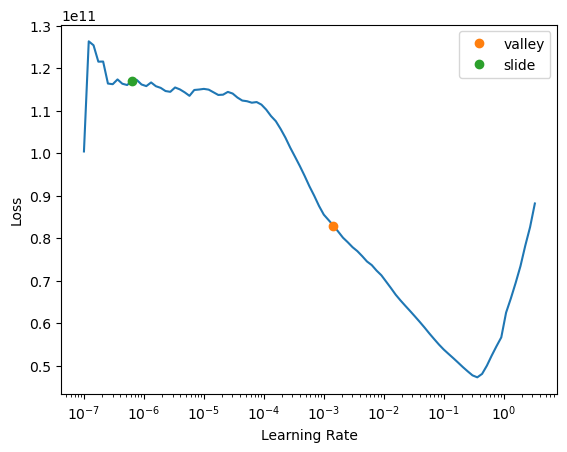

In [4]:
dls = fastai.TabularDataLoaders.from_df(df,procs=[fastai.Normalize],cont_names=["floor", "floor_area_sqm", "lease_commence_date", "date", "lat","long"],y_names=["resale_price"])
dls.show_batch()
def MSE(yhat,y):
  return torch.mean(torch.square(yhat-y))
def RMSE(yhat,y):
  return torch.sqrt(MSE(yhat,y))
learn = fastai.tabular_learner(dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),loss_func=MSE,metrics=RMSE)
learn.lr_find(suggest_funcs=(fastai.valley,fastai.slide))


In [10]:
learn = fastai.tabular_learner(
  dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),
  loss_func=MSE,metrics=RMSE,
  cbs=[fastai.SaveModelCallback(),fastai.EarlyStoppingCallback(patience=5)]
)
learn.fit_one_cycle(100,5e-2)
learn.validate()


Better model found at epoch 0 with valid_loss value: 49031.5703125.


(#2) [2420662016.0,49031.5703125]

In [11]:
# predict prices on map
row = df.drop(['resale_price'], axis=1).iloc[0].copy()
cats = ['floor', 'floor_area_sqm', 'lease_commence_date', 'date']
for cat in cats:
  row[cat] = df[cat].median()
latMin, latMax = df.lat.min(),df.lat.max()
latLeft = latMin - (latMax-latMin)/10
latRight = latMax + (latMax-latMin)/10
longMin, longMax = df.long.min(),df.long.max()
longLeft = longMin - (longMax-longMin)/10
longRight = longMax + (longMax-longMin)/10
n1 = 8*20
n2 = 5*20
longs = np.linspace(longLeft, longRight, n1)
lats = np.linspace(latLeft, latRight, n2)
prices = np.ndarray((n2,n1))
for i,lat in enumerate(lats):
  if i%10==0: print(f"{i} of {n2}") 
  row['lat'] = lat
  for j,long in enumerate(longs):
    row['long'] = long
    with learn.no_bar(), learn.no_logging():
      _, yPred, _ = learn.predict(row)
      prices[i][j] = yPred.item()

0 of 100
10 of 100
20 of 100
30 of 100
40 of 100
50 of 100
60 of 100
70 of 100
80 of 100
90 of 100


In [14]:
import http.client, urllib.parse
import json

mrts = ["Outram Park MRT", "Tiong Bahru MRT", "Redhill MRT", "Queenstown MRT", "Great World MRT", "Havelock MRT", "Maxwell MRT" "Chinatown MRT", "Telok Blangah MRT"]
longLats = load_pkl()

responses = []
for mrt in mrts:
	conn = http.client.HTTPConnection('api.positionstack.com')
	params = urllib.parse.urlencode({
		'access_key': key,
		'query': mrt[:-4] + ' Station',
		'region': 'Singapore',
		'limit': 1,
	})
	conn.request('GET', '/v1/forward?{}'.format(params))
	res = conn.getresponse()
	data = res.read()
	dataList = json.loads(data.decode('utf-8'))['data']
	if (len(dataList)==0): 
		print(f"check {mrt}. No data returned")
		count += 1
		errors.append(add)
		continue
	first_response = dataList[0]
	responses.append(first_response)
	if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
		longLats[f"{mrt}"] = (first_response['longitude'], first_response['latitude'])
		print(f"{first_response['label']}, confidence {first_response['confidence']}")
	else:
		print(f"check {mrt}. {first_response['label']}. confidence of {first_response['confidence']}")

dump_pkl(longLats)


longLats loaded. 4073
Chinatown Stn Exit C, Singapore, confidence 1
Telok Blangah Station, Singapore, confidence 1
pickle dumped. 4075


In [15]:
mrts = ["Outram Park MRT", "Tiong Bahru MRT", "Redhill MRT", "Queenstown MRT", "Great World MRT", "Havelock MRT", "Maxwell MRT", "Chinatown MRT", "Telok Blangah MRT"]
longLats['Maxwell MRT'] = (103.84403,1.28057)
dump_pkl(longLats)

pickle dumped. 4076


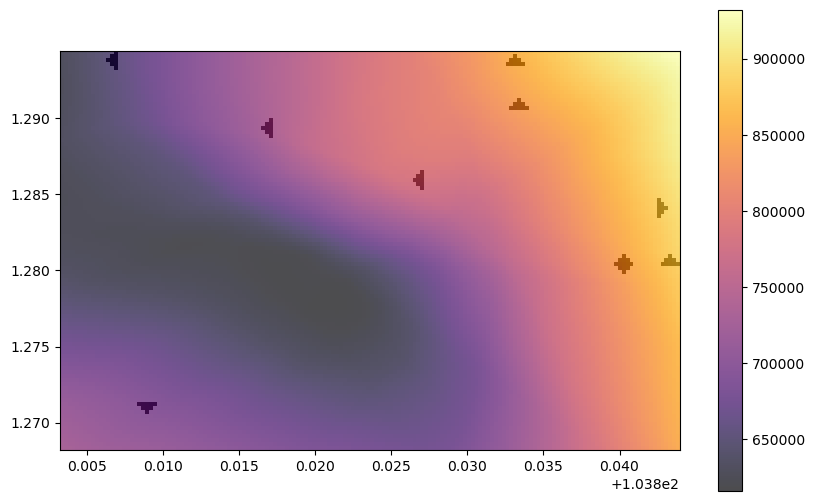

In [26]:
def min_coords(long,lat):
  return (np.abs((longs-long)).argmin(), np.abs(lats-lat).argmin())
def map_left(i,j):
  mrt_map[j-2][i+1]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+2][i+1]=1
def map_sq(i,j):
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+1][i-1]=1
def map_right(i,j):
  mrt_map[j-2][i-1]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+2][i-1]=1
def map_up(i,j):
  mrt_map[j+1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j-1][i-2]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i+2]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
def map_down(i,j):
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i-2]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+1][i+2]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+1][i]=1
def map_star(i,j):
  mrt_map[j+1][i]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j][i-2]=1
  mrt_map[j][i+2]=1
  mrt_map[j+2][i]=1
  mrt_map[j-2][i]=1
mrt_map = np.zeros((n2,n1))

mrts = ["Outram Park MRT", "Tiong Bahru MRT", "Redhill MRT", "Queenstown MRT", "Great World MRT", "Havelock MRT", "Maxwell MRT", "Chinatown MRT", "Telok Blangah MRT"]
map_star(*min_coords(*longLats[mrts[0]]))
map_left(*min_coords(*longLats[mrts[1]]))
map_left(*min_coords(*longLats[mrts[2]]))
#map_left(*min_coords(*longLats[mrts[3]]))
(i,j) = min_coords(*longLats[mrts[3]])
map_left(i,j-2)
#map_up(*min_coords(*longLats[mrts[4]]))
(i,j) = min_coords(*longLats[mrts[4]])
map_up(i,j-2)
map_up(*min_coords(*longLats[mrts[5]]))
#map_up(*min_coords(*longLats[mrts[6]]))
(i,j) = min_coords(*longLats[mrts[6]])
map_up(i-2,j)
map_right(*min_coords(*longLats[mrts[7]]))
map_down(*min_coords(*longLats[mrts[8]]))

fig,ax=plt.subplots()
#mrt
#color map
shw2 = ax.imshow(mrt_map, extent=[longLeft, longRight, latLeft, latRight], origin='lower',cmap='Greys',alpha=1.0)
shw = ax.imshow(prices, extent=[longLeft, longRight, latLeft, latRight], origin='lower',alpha=0.7, cmap='inferno')
bar = plt.colorbar(shw)
fig.set_figwidth(10)
fig.set_figheight(10/n1*n2)

plt.show()

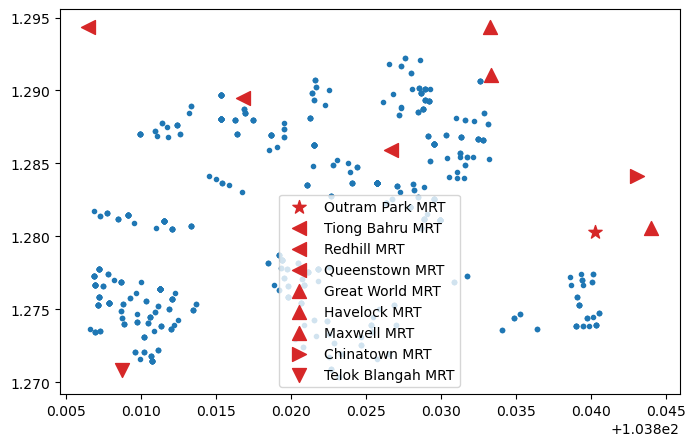

In [28]:
markers = ["*", '<', "<", '<', '^', '^', '^', '>', 'v']

fig,ax2=plt.subplots()
ax2.scatter(df.long,df.lat,marker='.')
for i,mrt in enumerate(mrts):
  ax2.scatter([longLats[mrt][0]], [longLats[mrt][1]],marker=markers[i],c='#d62728',label=mrt,s=100)
ax2.legend(loc='lower center')
fig.set_figwidth(8)
fig.set_figheight(8/n1*n2)

plt.show()

for mrt in mrts:
  (i,j) = min_coords(*longLats[mrt])
